In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import locale
from utils.graph import Graph
locale.setlocale(locale.LC_TIME, 'pt_BR.utf8')
util_graph = Graph()

# Carregar Dados

In [2]:
df_estoque_ruptura = pd.read_csv('../data/processed/dados_estoque_ruptura.csv')
df_estoque_ruptura['dt_estoque'] = pd.to_datetime(df_estoque_ruptura['dt_estoque'])
df_estoque_ruptura['ano_mes'] = df_estoque_ruptura['dt_estoque'].dt.strftime('%Y-%m')
df_estoque_ruptura['is_ruptura'] = df_estoque_ruptura['is_ruptura'].apply(int)
df_estoque_ruptura.head()

,key_loja,cod_produto,dt_estoque,qt_estoque,is_ruptura,ano_mes
0,1,1428,2024-01-01,108.0,0,2024-01
1,1,1428,2024-01-02,108.0,0,2024-01
2,1,1428,2024-01-03,108.0,0,2024-01
3,1,1428,2024-01-04,108.0,0,2024-01
4,1,1428,2024-01-05,108.0,0,2024-01


In [3]:
df_similares = pd.read_csv('../data/raw/tb_similares.csv')
df_similares.rename(columns={"cod_material": "cod_produto"}, inplace=True)
df_similares.head()

,cod_produto,cod_material_recom,ranking
0,48635,25472,1
1,50651,74932,1
2,48062,77684,1
3,49893,48730,1
4,49943,84203,1


In [4]:
df_vendas = pd.read_csv('../data/processed/df_vendas_consolidado.csv')
df_vendas['dt_venda'] = pd.to_datetime(df_vendas['dt_venda'])
df_vendas.head()

,dt_venda,key_loja,cod_produto,qtd_vendas,vlr_venda_tabelado_mean,vlr_desconto_mean,categoria_produto,sub_categoria_produto,linha_produto
0,2024-01-02,1,48062,1,284.70,0.0,217.0,422944,306420
1,2024-01-02,1,48635,1,419.70,0.0,955075.0,483679,284036
2,2024-01-02,1,82060,1,1017.00,191.1,157293.0,483679,120030
3,2024-01-02,2,1650,1,167.70,36.0,217.0,422944,731659
4,2024-01-02,2,48060,2,584.55,0.0,217.0,422944,306420


In [5]:
df_desc_prod = df_vendas[['cod_produto', 'key_loja' ,'categoria_produto', 'sub_categoria_produto', 'linha_produto']].drop_duplicates()
df_desc_prod['cod_produto'].value_counts()

cod_produto
48062    8
48635    8
82060    8
1650     8
48060    8
        ..
91669    5
83772    5
47910    1
3724     1
74932    1
Name: count, Length: 96, dtype: int64

In [6]:
df_tmp = df_estoque_ruptura.merge(df_similares, on='cod_produto', how='left')

df_estoque_ruptura_similar = df_tmp.merge(
    df_estoque_ruptura,
    left_on=['cod_material_recom', 'key_loja', 'dt_estoque'],
    right_on=['cod_produto', 'key_loja', 'dt_estoque'],
    how='left',
    suffixes=('', '_similar')
)

df_estoque_ruptura_similar['similar_disponivel'] = df_estoque_ruptura_similar['qt_estoque_similar'] > 0
df_estoque_ruptura_similar['similar_disponivel'] = df_estoque_ruptura_similar['similar_disponivel'].apply(int)

df_estoque_ruptura_similar.drop(columns=['cod_material_recom', 'is_ruptura_similar', 'ano_mes_similar'], inplace=True)

df_estoque_ruptura_similar.head()

,key_loja,cod_produto,dt_estoque,qt_estoque,is_ruptura,ano_mes,ranking,cod_produto_similar,qt_estoque_similar,similar_disponivel
0,1,1428,2024-01-01,108.0,0,2024-01,1.0,1650.0,102.0,1
1,1,1428,2024-01-01,108.0,0,2024-01,2.0,1640.0,83.0,1
2,1,1428,2024-01-01,108.0,0,2024-01,3.0,48282.0,335.0,1
3,1,1428,2024-01-02,108.0,0,2024-01,1.0,1650.0,102.0,1
4,1,1428,2024-01-02,108.0,0,2024-01,2.0,1640.0,83.0,1


# Como os Produtos Similares estão se Comportando quando ocorre ruptura?

## Loja 7

In [7]:
lj = 7

In [8]:
df_loja = df_estoque_ruptura_similar[(df_estoque_ruptura_similar['key_loja']==lj)&(df_estoque_ruptura_similar['is_ruptura']==1)]

### Qual Ranking tem mais Recomendação ?

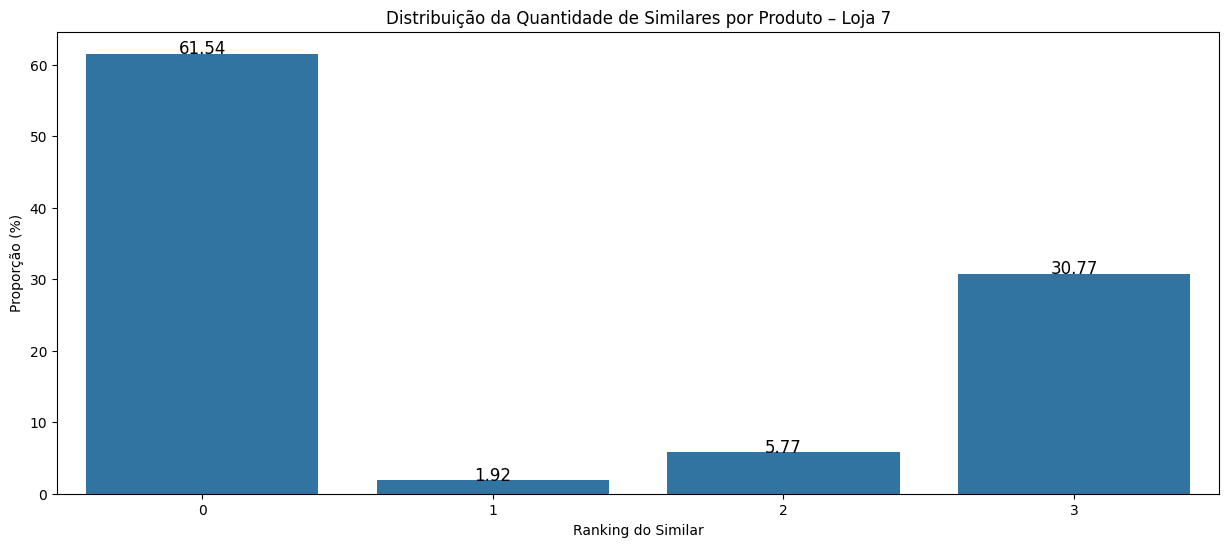

In [9]:
df_ranking_por_produto = df_loja.groupby('cod_produto')['ranking'].nunique().reset_index(name='qtd_similares')
df_dist_similares = df_ranking_por_produto['qtd_similares'].value_counts(normalize=True).sort_index().reset_index()
df_dist_similares['proportion'] = np.round(df_dist_similares['proportion']*100,2)

util_graph.create_graph_bar(df_dist_similares, 'qtd_similares', 'proportion', 'Ranking do Similar', 'Proporção (%)', f'Distribuição da Quantidade de Similares por Produto – Loja {lj}')

- A loja apresenta baixa cobertura
- A maioria tem três opções de similares, o que é positivo.

### Qual o Grau de Disponibilidade por Ranking ?

In [10]:
df_loja_desc_prod = df_loja.merge(df_desc_prod, on=['cod_produto','key_loja'], how='left')
df_loja_desc_prod[df_loja_desc_prod['categoria_produto'].isnull()]['cod_produto'].unique()

array([24499, 28694, 47910, 48253, 49186, 49824, 57042, 58236, 58565,
       74932, 75610, 82026, 82250, 82719, 83772, 84064, 84068, 85124])

In [11]:
df_loja_similar = df_loja_desc_prod[~df_loja_desc_prod['ranking'].isnull()]
df_loja_similar.head()

,key_loja,cod_produto,dt_estoque,qt_estoque,is_ruptura,ano_mes,ranking,cod_produto_similar,qt_estoque_similar,similar_disponivel,categoria_produto,sub_categoria_produto,linha_produto
0,7,1428,2024-06-04,0.0,1,2024-06,1.0,1650.0,0.0,0,217.0,422944.0,731659.0
1,7,1428,2024-06-04,0.0,1,2024-06,2.0,1640.0,0.0,0,217.0,422944.0,731659.0
2,7,1428,2024-06-04,0.0,1,2024-06,3.0,48282.0,0.0,0,217.0,422944.0,731659.0
3,7,1428,2024-06-05,0.0,1,2024-06,1.0,1650.0,0.0,0,217.0,422944.0,731659.0
4,7,1428,2024-06-05,0.0,1,2024-06,2.0,1640.0,0.0,0,217.0,422944.0,731659.0


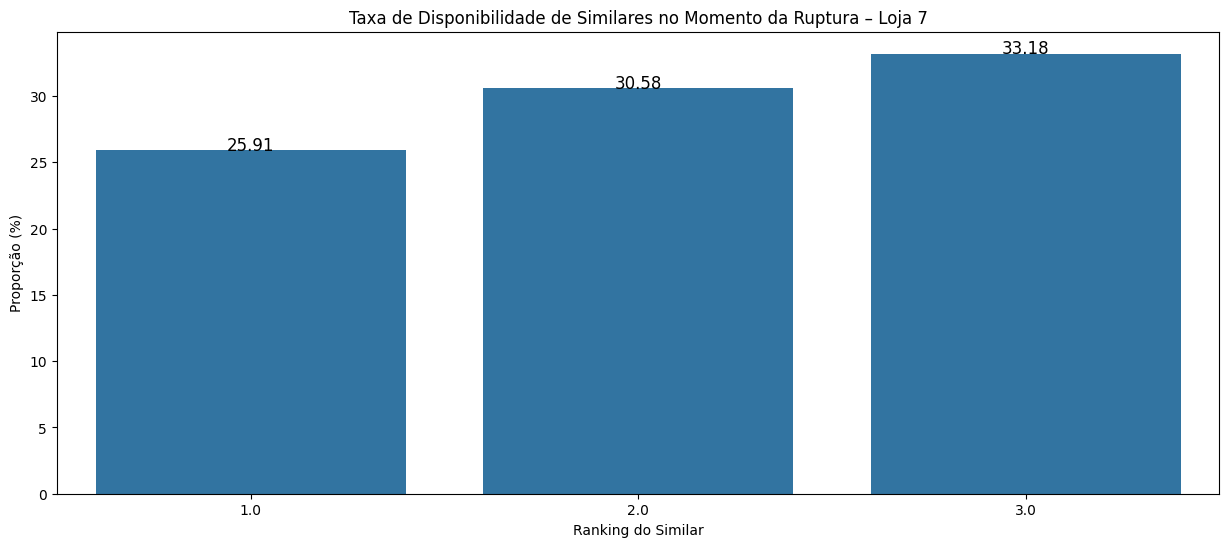

In [12]:
disponibilidade_por_rank = (
    df_loja_similar.groupby(['ranking'], as_index=False)['similar_disponivel']
    .agg(qtd_similares_disponiveis='sum', total='count')
    .assign(taxa_disponibilidade=lambda x: np.round((x['qtd_similares_disponiveis'] / x['total'])*100,2))
    )
disponibilidade_por_rank

util_graph.create_graph_bar(disponibilidade_por_rank, 'ranking', 'taxa_disponibilidade', 'Ranking do Similar', 
                 'Proporção (%)', f'Taxa de Disponibilidade de Similares no Momento da Ruptura – Loja {lj}')

- Mesmo quando há similar recomendado, a maioria não está disponível no estoque no momento da ruptura.
- O ranking mais parecido (1.0) é o menos disponível, dificultando a substituição natural.
- Rankings menos parecidos têm leve melhora na disponibilidade, mas ainda menos de 1 em cada 3 estão prontos para substituir

### Qual o Ranking mais Vendido?

In [13]:
df_loja_similar_disponivel = df_loja_similar[df_loja_similar['similar_disponivel']==1]

vendas_similares = df_loja_similar_disponivel.merge(
    df_vendas[['dt_venda', 'key_loja', 'cod_produto', 'qtd_vendas', 'vlr_venda_tabelado_mean', 'vlr_desconto_mean']], 
    left_on=['cod_produto_similar', 'key_loja', 'dt_estoque'], 
    right_on=['cod_produto', 'key_loja', 'dt_venda'], how='left',
    suffixes=('', '_similar_venda'))

vendas_similares.drop(columns=['categoria_produto', 'sub_categoria_produto', 'linha_produto', 'cod_produto_similar_venda'], inplace=True)
vendas_similares['venda_similar'] = vendas_similares['qtd_vendas']>0
vendas_similares['venda_similar'] = vendas_similares['venda_similar'].apply(int)
vendas_similares.head()

,key_loja,cod_produto,dt_estoque,qt_estoque,is_ruptura,ano_mes,ranking,cod_produto_similar,qt_estoque_similar,similar_disponivel,dt_venda,qtd_vendas,vlr_venda_tabelado_mean,vlr_desconto_mean,venda_similar
0,7,1428,2024-06-23,0.0,1,2024-06,2.0,1640.0,2.0,1,NaT,NaN,NaN,NaN,0
1,7,1428,2024-06-23,0.0,1,2024-06,3.0,48282.0,428.0,1,NaT,NaN,NaN,NaN,0
2,7,1428,2024-06-24,0.0,1,2024-06,2.0,1640.0,2.0,1,NaT,NaN,NaN,NaN,0
3,7,1428,2024-06-24,0.0,1,2024-06,3.0,48282.0,428.0,1,2024-06-24,14.0,329.571429,0.0,1
4,7,1428,2024-06-25,0.0,1,2024-06,2.0,1640.0,2.0,1,NaT,NaN,NaN,NaN,0


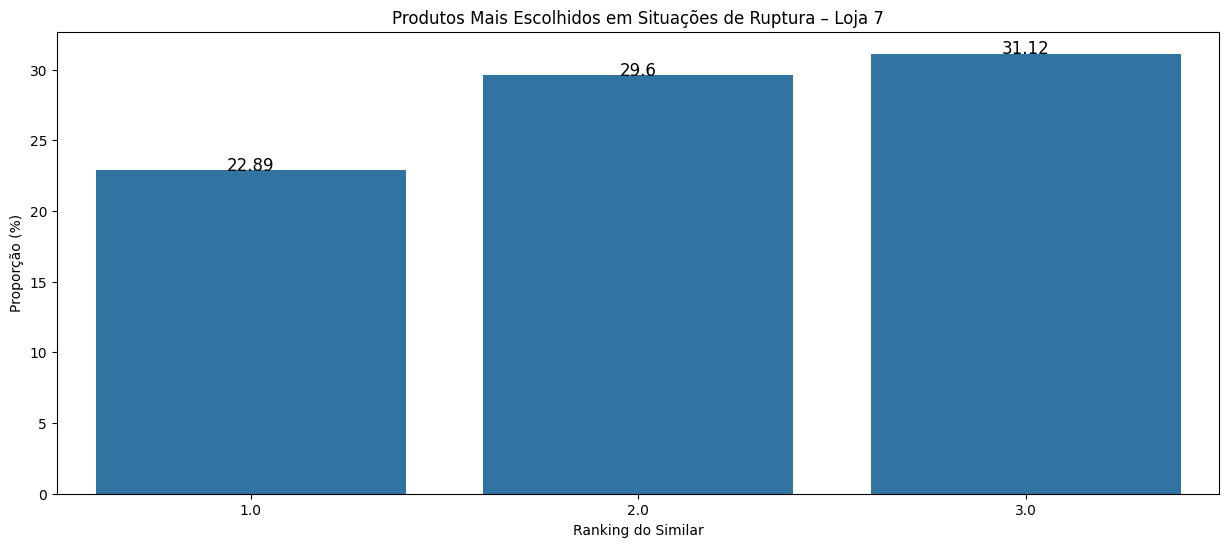

In [14]:
resultado_substituicao_similar = vendas_similares.groupby(['dt_estoque', 'key_loja', 'cod_produto', 'ranking'],as_index=False)['venda_similar'].max()
taxa_substituicao = (
    resultado_substituicao_similar.groupby(['ranking'],as_index=False)['venda_similar']
    .agg(qtd_vendas_similares='sum', total='count')
    .assign(taxa_substituicao=lambda x: np.round((x['qtd_vendas_similares'] / x['total'])*100, 2))
    )

util_graph.create_graph_bar(taxa_substituicao, 'ranking', 'taxa_substituicao', 'Ranking do Similar', 'Proporção (%)', f'Produtos Mais Escolhidos em Situações de Ruptura – Loja {lj}')

- O ranking 3 (menos parecido) foi o mais escolhido em situações de ruptura.
- O ranking 1, que deveria ser o preferido, foi o menos vendido.
- Indica que o ranking atual de similaridade não representa bem a preferência real do consumidor na loja 7.

### Diferença do Preço em Relação ao Produto com Ruptura Importa na Preferência do Similar ?

In [15]:
valores_produtos = df_vendas.groupby(['cod_produto', 'key_loja'], as_index=False).agg({'vlr_venda_tabelado_mean':'mean', 'vlr_desconto_mean':'mean'})
valores_produtos.head()

,cod_produto,key_loja,vlr_venda_tabelado_mean,vlr_desconto_mean
0,1428,1,282.623476,41.581585
1,1428,2,295.103066,35.989608
2,1428,3,313.755580,47.799176
3,1428,4,277.357283,38.888882
4,1428,5,325.515359,47.817937


In [16]:
produtos_precos = vendas_similares.merge(
    valores_produtos, 
    left_on=['cod_produto', 'key_loja'], 
    right_on=['cod_produto', 'key_loja'], how='left',
    suffixes=('', '_principal'))

produtos_precos.drop(columns=['dt_venda', 'qtd_vendas', 'vlr_venda_tabelado_mean', 'vlr_desconto_mean'], inplace=True)

vendas_produtos_similar_precos = produtos_precos.merge(
    valores_produtos, 
    left_on=['cod_produto_similar', 'key_loja'], 
    right_on=['cod_produto', 'key_loja'], how='left',
    suffixes=('', '_similar'))

vendas_produtos_similar_precos.drop(columns=['cod_produto_similar'], inplace=True)

vendas_produtos_similar_precos['valor_final_principal'] = vendas_produtos_similar_precos['vlr_venda_tabelado_mean_principal'] - vendas_produtos_similar_precos['vlr_desconto_mean_principal']
vendas_produtos_similar_precos['valor_final_similar'] = vendas_produtos_similar_precos['vlr_venda_tabelado_mean'] - vendas_produtos_similar_precos['vlr_desconto_mean']
vendas_produtos_similar_precos['diff_vlr_final'] = np.round(vendas_produtos_similar_precos['valor_final_similar']-vendas_produtos_similar_precos['valor_final_principal'], 2)

vendas_produtos_similar_precos.loc[vendas_produtos_similar_precos['diff_vlr_final']>0, 'flag_diff_preco'] = 'Mais Caro'
vendas_produtos_similar_precos.loc[vendas_produtos_similar_precos['diff_vlr_final']==0, 'flag_diff_preco'] = 'Mesmo Valor'
vendas_produtos_similar_precos.loc[vendas_produtos_similar_precos['diff_vlr_final']<0, 'flag_diff_preco'] = 'Mais Barato'
vendas_produtos_similar_precos.loc[vendas_produtos_similar_precos['valor_final_principal'].isnull(), 'flag_diff_preco'] = 'Principal Sem Preço'

vendas_produtos_similar_precos['ranking'] = vendas_produtos_similar_precos['ranking'].astype(str)
vendas_produtos_similar_precos['rank_flag_diff'] = 'R: '+ vendas_produtos_similar_precos['ranking'] + ' - F: ' + vendas_produtos_similar_precos['flag_diff_preco']

vendas_produtos_similar_precos.head()

,key_loja,cod_produto,dt_estoque,qt_estoque,is_ruptura,ano_mes,ranking,qt_estoque_similar,similar_disponivel,venda_similar,vlr_venda_tabelado_mean_principal,vlr_desconto_mean_principal,vlr_venda_tabelado_mean,vlr_desconto_mean,valor_final_principal,valor_final_similar,diff_vlr_final,flag_diff_preco,rank_flag_diff
0,7,1428,2024-06-23,0.0,1,2024-06,2.0,2.0,1,0,282.308108,31.426757,197.670000,17.778000,250.881351,179.892000,-70.99,Mais Barato,R: 2.0 - F: Mais Barato
1,7,1428,2024-06-23,0.0,1,2024-06,3.0,428.0,1,0,282.308108,31.426757,310.994146,17.884851,250.881351,293.109296,42.23,Mais Caro,R: 3.0 - F: Mais Caro
2,7,1428,2024-06-24,0.0,1,2024-06,2.0,2.0,1,0,282.308108,31.426757,197.670000,17.778000,250.881351,179.892000,-70.99,Mais Barato,R: 2.0 - F: Mais Barato
3,7,1428,2024-06-24,0.0,1,2024-06,3.0,428.0,1,1,282.308108,31.426757,310.994146,17.884851,250.881351,293.109296,42.23,Mais Caro,R: 3.0 - F: Mais Caro
4,7,1428,2024-06-25,0.0,1,2024-06,2.0,2.0,1,0,282.308108,31.426757,197.670000,17.778000,250.881351,179.892000,-70.99,Mais Barato,R: 2.0 - F: Mais Barato


In [17]:
qtd_opcoes = (vendas_produtos_similar_precos.groupby(['dt_estoque', 'cod_produto', 'key_loja'],as_index=False).agg({'ranking':'count'}))
qtd_opcoes.rename(columns={'ranking':'qtd_opcoes'},inplace=True)
vendas_produtos_similar_precos = vendas_produtos_similar_precos.merge(qtd_opcoes, on=['dt_estoque', 'cod_produto', 'key_loja'], how='left')

In [18]:
produtos_disponiveis = (
    vendas_produtos_similar_precos.groupby(['dt_estoque', 'cod_produto', 'key_loja'],as_index=False)
    .agg({'rank_flag_diff':lambda x: ' | '.join(str(i) for i in x)}))
produtos_disponiveis.rename(columns={'rank_flag_diff':'similares_disponiveis'},inplace=True)
produtos_disponiveis

vendas_produtos_similar_precos = vendas_produtos_similar_precos.merge(produtos_disponiveis, on=['dt_estoque', 'cod_produto', 'key_loja'], how='left')

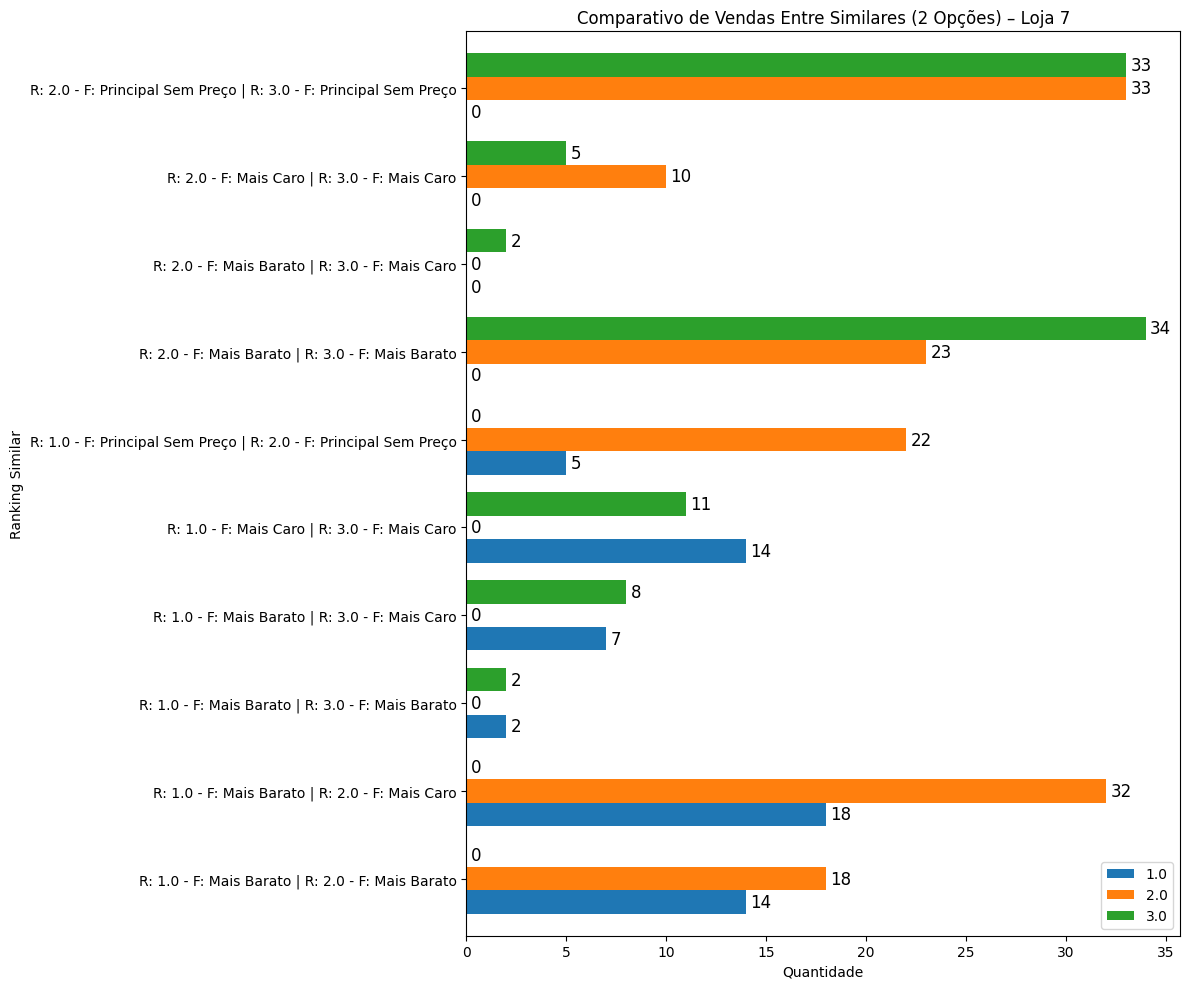

In [19]:
distribuicao_vendas = vendas_produtos_similar_precos[(vendas_produtos_similar_precos['venda_similar']==1)&(vendas_produtos_similar_precos['qtd_opcoes']==2)].groupby('similares_disponiveis', as_index=False)['ranking'].value_counts()
util_graph.create_graph_multi_bar(distribuicao_vendas, 'similares_disponiveis', 'ranking', 'count', 'Ranking Similar', 'Quantidade', 
                                  f'Comparativo de Vendas Entre Similares (2 Opções) – Loja {lj}', '')

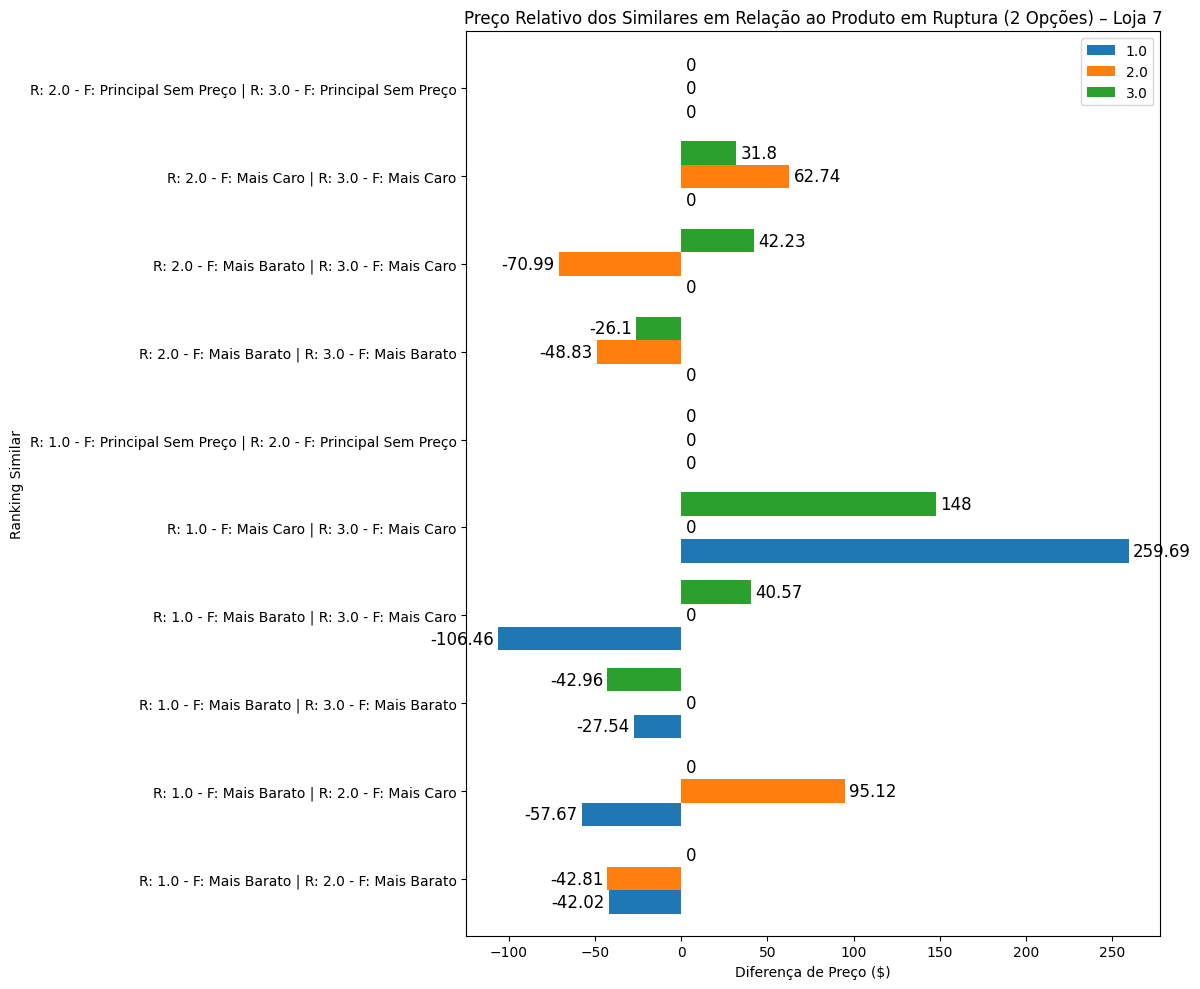

In [24]:
resultado_diff = vendas_produtos_similar_precos[(vendas_produtos_similar_precos['qtd_opcoes']==2)].groupby(['similares_disponiveis','ranking'],as_index=False)['diff_vlr_final'].mean()
resultado_diff['diff_vlr_final'] = resultado_diff['diff_vlr_final'].round(2)

util_graph.create_graph_multi_bar(resultado_diff, 'similares_disponiveis', 'ranking', 'diff_vlr_final', 'Ranking Similar', 'Diferença de Preço ($)', 
                                  f'Preço Relativo dos Similares em Relação ao Produto em Ruptura (2 Opções) – Loja {lj}', '')

- Preço baixo nem sempre garante preferência
- Ranking 2 vendeu mais, mesmo sendo menos parecido.

- Produtos menos parecidos (ranking 3) venderam mais mesmo sendo mais caros

- A similaridade técnica (ranking) não é o principal fator na decisão de compra.

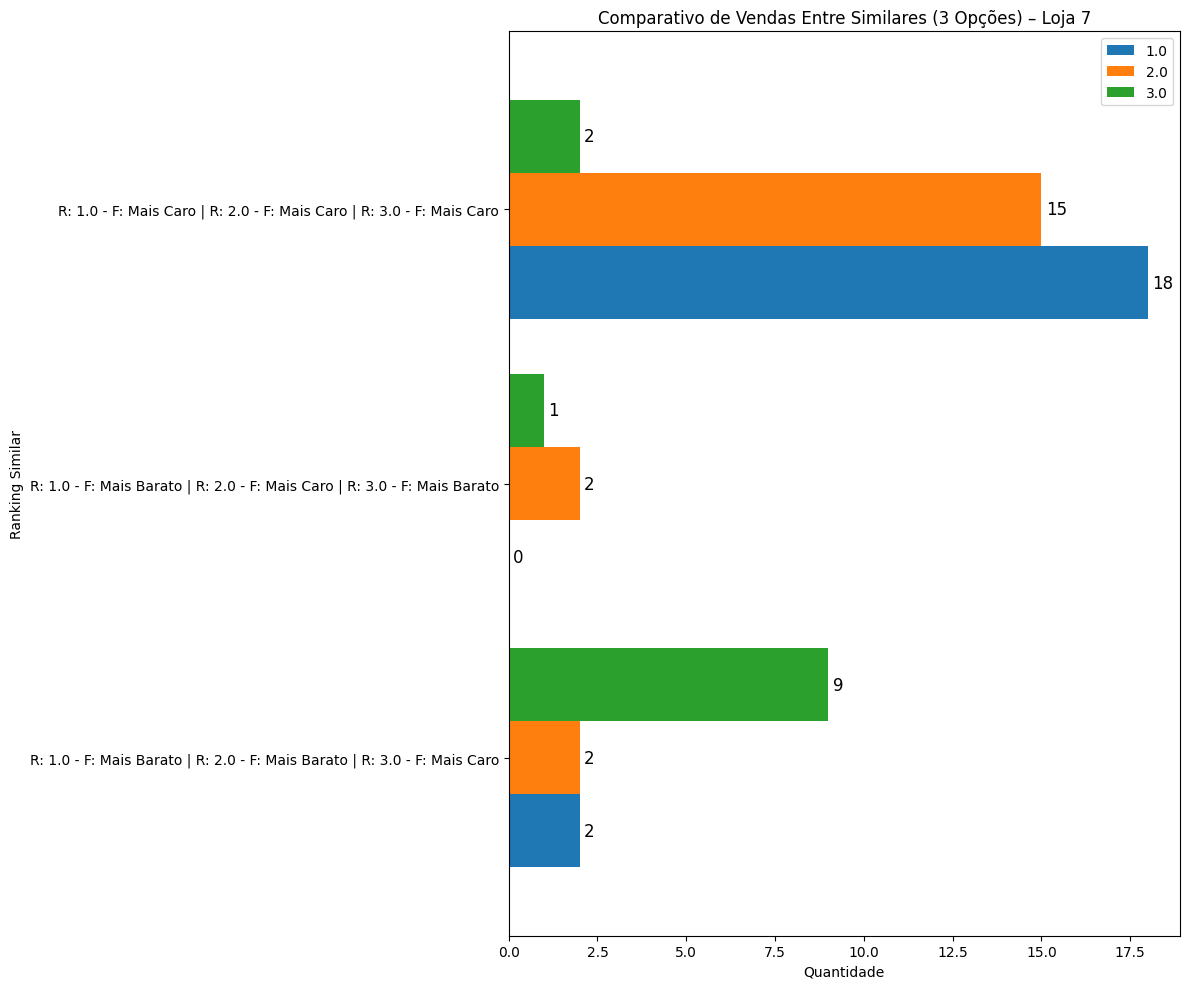

In [21]:
distribuicao_vendas = vendas_produtos_similar_precos[(vendas_produtos_similar_precos['venda_similar']==1)&(vendas_produtos_similar_precos['qtd_opcoes']==3)].groupby('similares_disponiveis', as_index=False)['ranking'].value_counts()
util_graph.create_graph_multi_bar(distribuicao_vendas, 'similares_disponiveis', 'ranking', 'count', 'Ranking Similar', 'Quantidade', 
                                  f'Comparativo de Vendas Entre Similares (3 Opções) – Loja {lj}', '')

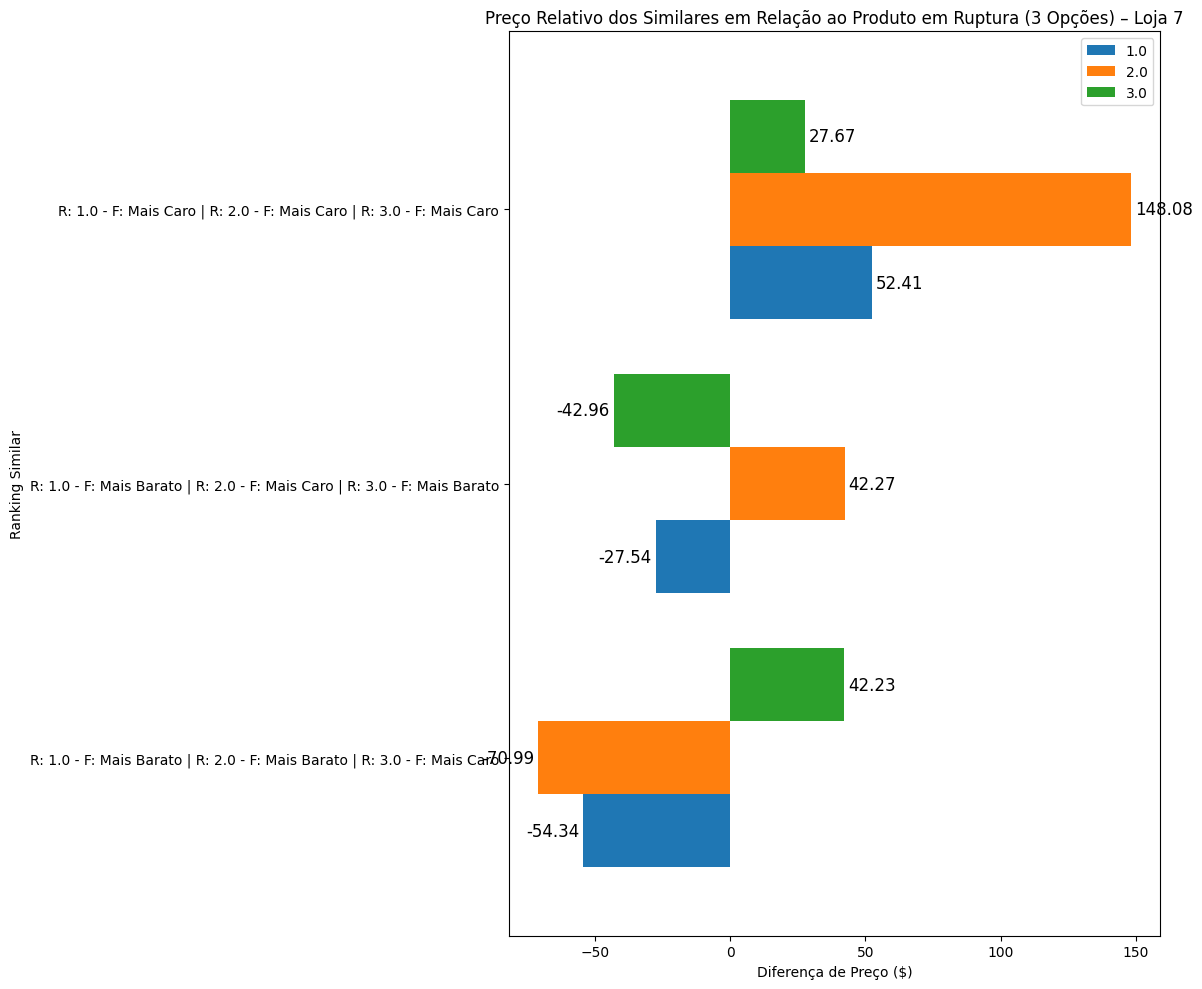

In [23]:
resultado_diff = vendas_produtos_similar_precos[(vendas_produtos_similar_precos['qtd_opcoes']==3)].groupby(['similares_disponiveis','ranking'],as_index=False)['diff_vlr_final'].mean()
resultado_diff['diff_vlr_final'] = resultado_diff['diff_vlr_final'].round(2)

util_graph.create_graph_multi_bar(resultado_diff, 'similares_disponiveis', 'ranking', 'diff_vlr_final', 'Ranking Similar', 'Diferença de Preço ($)', 
                                  f'Preço Relativo dos Similares em Relação ao Produto em Ruptura (3 Opções) – Loja {lj}', '')

- O mais caro pode vender mais, mesmo com opções mais baratas e parecidas

- Quando os três similares são caros, o mais parecido ainda lidera (por pouco)

- Quando dois são baratos e um caro, nem sempre o barato vende mais

# Conclusão

- Baixa Cobertura de Similares
    - 61,54% dos produtos não possuem nenhum similar recomendado.
    - Apenas 38,46% têm ao menos uma alternativa, e a maioria desses possui 3 opções.
    - A maioria das rupturas ocorre sem qualquer plano de substituição, resultando em perda de vendas direta.

- Baixa Disponibilidade dos Similares no Estoque
    - Mesmo com recomendação, os similares frequentemente não estão disponíveis, o que limita a conversão em vendas.

- Ranking Inferior é o Mais Vendido
    - O cliente ignora a similaridade técnica e escolhe produtos de menor ranking, possivelmente por fatores mais atrativos como marca, apresentação ou preferência pessoal.

- Preço Não É Fator Decisivo
    - Casos observados onde o produto mais caro foi o mais vendido, mesmo com opções mais baratas disponíveis.
    - O preço sozinho não determina a escolha